<a href="https://colab.research.google.com/github/ZaichenkoNA/Stat_Prac/blob/main/Proekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
credits_df = pd.read_csv("./drive/MyDrive/credits.csv", low_memory=False)
titles_df = pd.read_csv("./drive/MyDrive/titles.csv", low_memory=False)

print(credits_df.head())
print(titles_df.head())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   person_id       id             name                character   role
0       3748  tm84618   Robert De Niro            Travis Bickle  ACTOR
1      14658  tm84618     Jodie Foster            Iris Steensma  ACTOR
2       7064  tm84618    Albert Brooks                      Tom  ACTOR
3       3739  tm84618    Harvey Keitel  Matthew 'Sport' Higgins  ACTOR
4      48933  tm84618  Cybill Shepherd                    Betsy  ACTOR
         id                                title   type  \
0  ts300399  Five Came Back: The Reference Films   SHOW   
1   tm84618                          Taxi Driver  MOVIE   
2  tm154986                          Deliverance  MOVIE   
3  tm127384      Monty Python and the Holy Grail  MOVIE   
4  tm120801                      The Dirty Dozen  MOVIE   

                                         description  release_year  \
0  This collection i

In [13]:
print(credits_df.info())
print(titles_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77801 entries, 0 to 77800
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   person_id  77801 non-null  int64 
 1   id         77801 non-null  object
 2   name       77801 non-null  object
 3   character  68029 non-null  object
 4   role       77801 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64 

In [14]:

print(titles_df.describe())

       release_year      runtime      seasons   imdb_score    imdb_votes  \
count   5850.000000  5850.000000  2106.000000  5368.000000  5.352000e+03   
mean    2016.417094    76.888889     2.162868     6.510861  2.343938e+04   
std        6.937726    39.002509     2.689041     1.163826  9.582047e+04   
min     1945.000000     0.000000     1.000000     1.500000  5.000000e+00   
25%     2016.000000    44.000000     1.000000     5.800000  5.167500e+02   
50%     2018.000000    83.000000     1.000000     6.600000  2.233500e+03   
75%     2020.000000   104.000000     2.000000     7.300000  9.494000e+03   
max     2022.000000   240.000000    42.000000     9.600000  2.294231e+06   

       tmdb_popularity   tmdb_score  
count      5759.000000  5539.000000  
mean         22.637925     6.829175  
std          81.680263     1.170391  
min           0.009442     0.500000  
25%           2.728500     6.100000  
50%           6.821000     6.900000  
75%          16.590000     7.537500  
max        

Проверим отсутствующие данные:

In [15]:
credits_df.isna().sum()


,0
person_id,0
id,0
name,0
character,9772
role,0


In [16]:
titles_df.isna().sum()

,0
id,0
title,1
type,0
description,18
release_year,0
age_certification,2619
runtime,0
genres,0
production_countries,0
seasons,3744


Обработка данных:

In [17]:
import pandas as pd

# Разделяем актеров и режиссеров
actors_df = credits_df[credits_df['role'] == 'ACTOR'].copy()
directors_df = credits_df[credits_df['role'] == 'DIRECTOR'].copy()

# 1. Фичи для актеров
# Популярность актеров (по количеству фильмов)
actor_counts = actors_df["name"].value_counts()
actors_df["actor_popularity"] = actors_df["name"].map(actor_counts)

# Средняя популярность актеров в фильме
actor_popularity_per_movie = actors_df.groupby("id")["actor_popularity"].mean().reset_index()
actor_popularity_per_movie.rename(columns={"actor_popularity": "avg_actor_popularity"}, inplace=True)

# Количество актеров в фильме
actor_count_per_movie = actors_df.groupby("id")["person_id"].count().reset_index()
actor_count_per_movie.rename(columns={"person_id": "num_actors"}, inplace=True)

# Наличие топ-актера в фильме
top_100_actors = set(actor_counts.head(100).index)
actors_df["has_top_actor"] = actors_df["name"].isin(top_100_actors)
top_actor_flag_per_movie = actors_df.groupby("id")["has_top_actor"].max().reset_index()

# 3. Объединяем все фичи с основной таблицей
titles_df = titles_df.merge(actor_popularity_per_movie, on="id", how="left")
titles_df = titles_df.merge(actor_count_per_movie, on="id", how="left")
titles_df = titles_df.merge(top_actor_flag_per_movie, on="id", how="left")




Обработаем пропуски:

In [18]:
titles_df["avg_actor_popularity"] = titles_df["avg_actor_popularity"].fillna(0)
titles_df["num_actors"] = titles_df["num_actors"].fillna(0)
titles_df["has_top_actor"] = titles_df["has_top_actor"].fillna(False)
titles_df["runtime"] = titles_df["runtime"].fillna(titles_df["runtime"].median())
titles_df["tmdb_popularity"] = titles_df["tmdb_popularity"].fillna(0)
titles_df["imdb_votes"] = titles_df["imdb_votes"].fillna(0)
titles_df = titles_df.dropna(subset=['imdb_score'])

<ipython-input-18-7b97257f4604>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  titles_df["has_top_actor"] = titles_df["has_top_actor"].fillna(False)


In [19]:
titles_df.isna().sum()

,0
id,0
title,0
type,0
description,5
release_year,0
age_certification,2335
runtime,0
genres,0
production_countries,0
seasons,3429


In [20]:
# Обработка жанров (one-hot encoding)
genres_exploded = titles_df["genres"].str.strip("[]").str.replace("'", "").str.split(", ")
unique_genres = set(
    genre
    for sublist in genres_exploded.dropna()
    for genre in sublist
    if genre.strip()  # Игнорируем пустые строки ("")
)

# Создаём бинарные столбцы только для непустых жанров
genre_df = pd.DataFrame({
    f"genre_{genre}": genres_exploded.apply(lambda x: genre in x if isinstance(x, list) else False)
    for genre in unique_genres
})
titles_df = pd.concat([titles_df, genre_df], axis=1)


In [21]:
# Обработка стран (one-hot encoding)
countries_exploded = titles_df["production_countries"].str.strip("[]").str.replace("'", "").str.split(", ")
unique_countries = set(
    country
    for sublist in countries_exploded.dropna()
    for country in sublist
    if country.strip()  # Игнорируем пустые строки ("")
)
country_df = pd.DataFrame({
    f"country_{country}": countries_exploded.apply(lambda x: country in x if isinstance(x, list) else False)
    for country in unique_countries
})
titles_df = pd.concat([titles_df, country_df], axis=1)

titles_df = titles_df.dropna(subset=["imdb_score"])
print("Предобработка завершена!")

Предобработка завершена!


Найдём распределения:

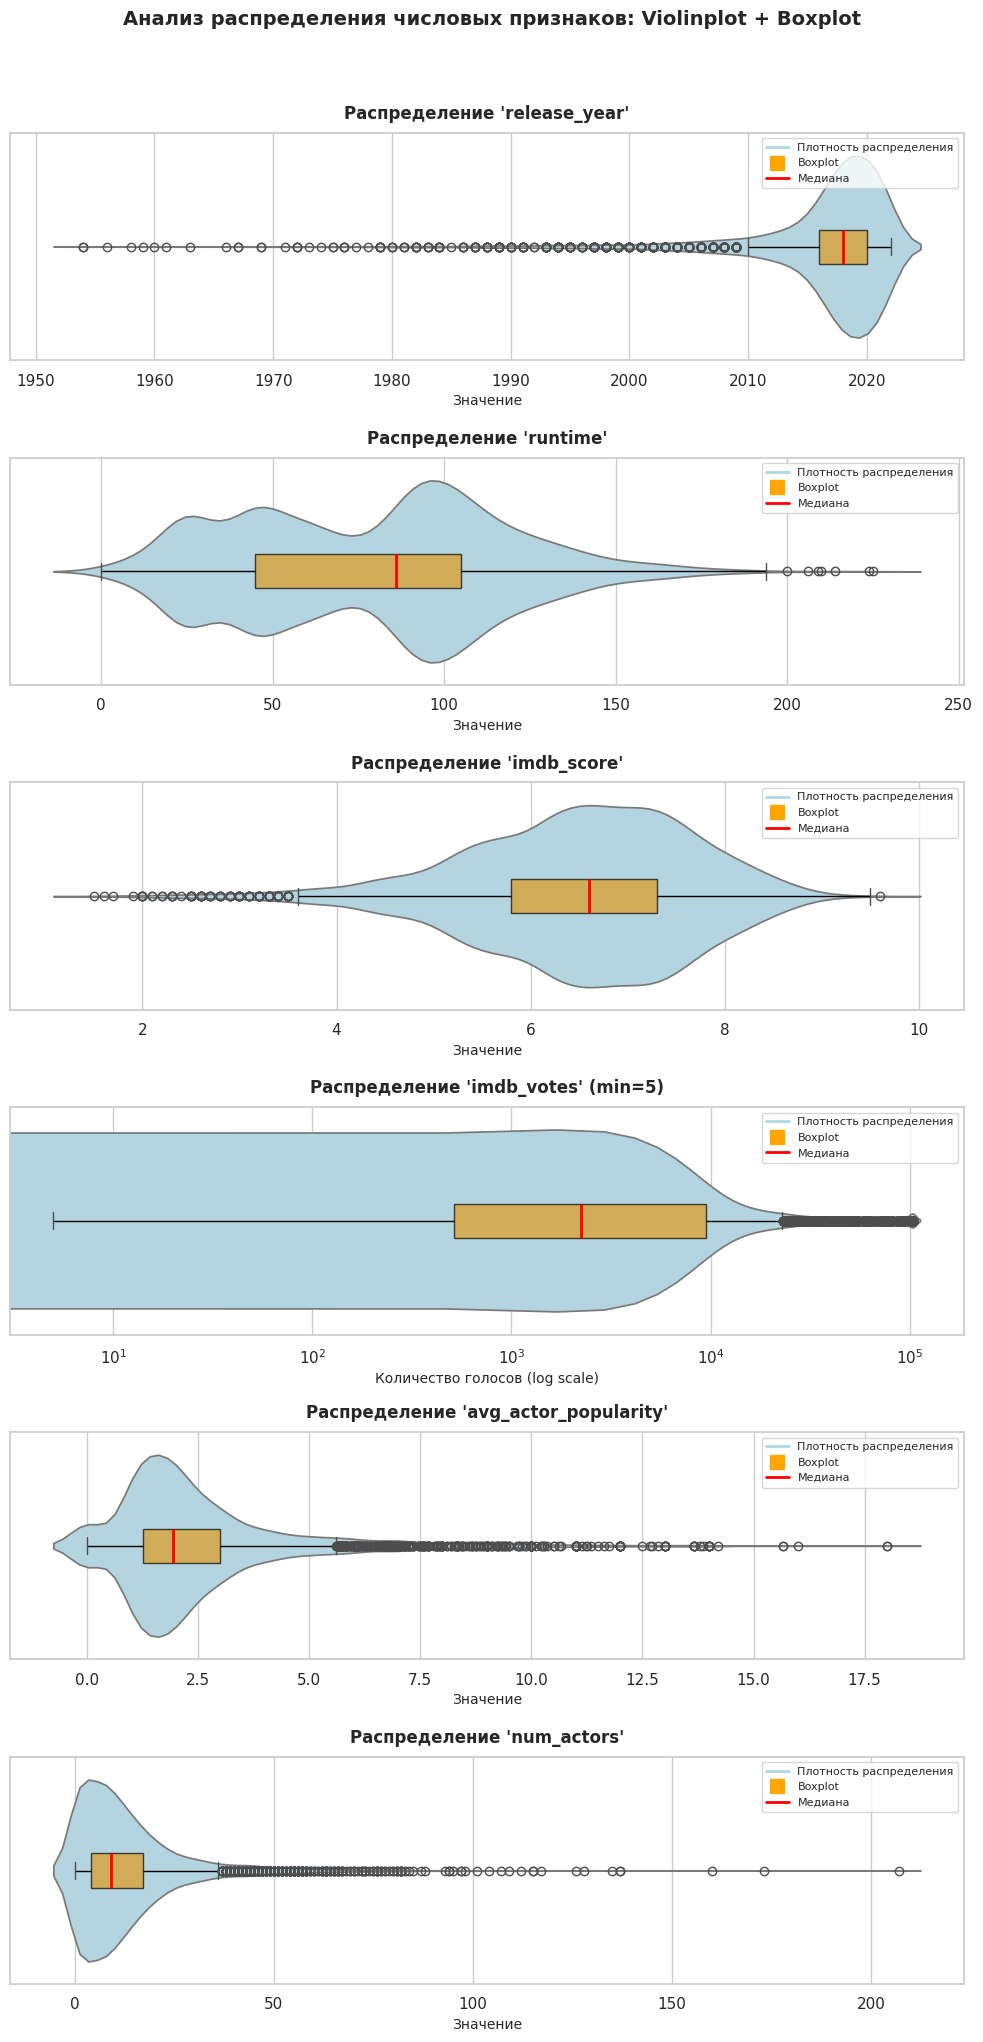

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import mstats
import numpy as np

sns.set_theme(style="whitegrid", palette="husl")

numeric_features = ["release_year", "runtime", "imdb_score", "imdb_votes", "avg_actor_popularity", "num_actors"]

fig, axes = plt.subplots(len(numeric_features), 1, figsize=(10, 20), dpi=100)

for i, feature in enumerate(numeric_features):
    ax = axes[i]
    data = titles_df[feature].copy()

    # Обработка imdb_votes
    if feature == 'imdb_votes':
        # Удаление нулевых значений перед логарифмированием
        data = data[data > 0]
        # Обрезка верхних 5% выбросов
        data = mstats.winsorize(data, limits=[0, 0.05])
        sns.violinplot(
            x=data,
            ax=ax,
            inner=None,
            color='lightblue',
            width=0.8
        )
        sns.boxplot(
            x=data,
            ax=ax,
            width=0.15,
            color='orange',
            boxprops={'alpha': 0.7, 'edgecolor': 'black'},
            whiskerprops={'color': 'black'},
            medianprops={'color': 'red', 'linewidth': 2}
        )

        # Логарифмическая шкала
        ax.set_xscale('log')
        ax.set_xlabel("Количество голосов (log scale)", fontsize=10)

        # Добавляем информацию о минимальном значении
        min_val = data.min()
        ax.set_title(f"Распределение '{feature}' (min={min_val:.0f})", fontsize=12, pad=10, fontweight="bold")

    else:
        # Обычная обработка для других признаков
        sns.violinplot(
            x=data,
            ax=ax,
            inner=None,
            color='lightblue',
            width=0.8
        )
        sns.boxplot(
            x=data,
            ax=ax,
            width=0.15,
            color='orange',
            boxprops={'alpha': 0.7, 'edgecolor': 'black'},
            whiskerprops={'color': 'black'},
            medianprops={'color': 'red', 'linewidth': 2}
        )
        ax.set_xlabel("Значение", fontsize=10)
        ax.set_title(f"Распределение '{feature}'", fontsize=12, pad=10, fontweight="bold")

    legend_elements = [
        Line2D([], [], color='lightblue', linewidth=2, label='Плотность распределения'),
        Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, label='Boxplot'),
        Line2D([], [], color='red', linewidth=2, label='Медиана')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

plt.suptitle("Анализ распределения числовых признаков: Violinplot + Boxplot",
             fontsize=14, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

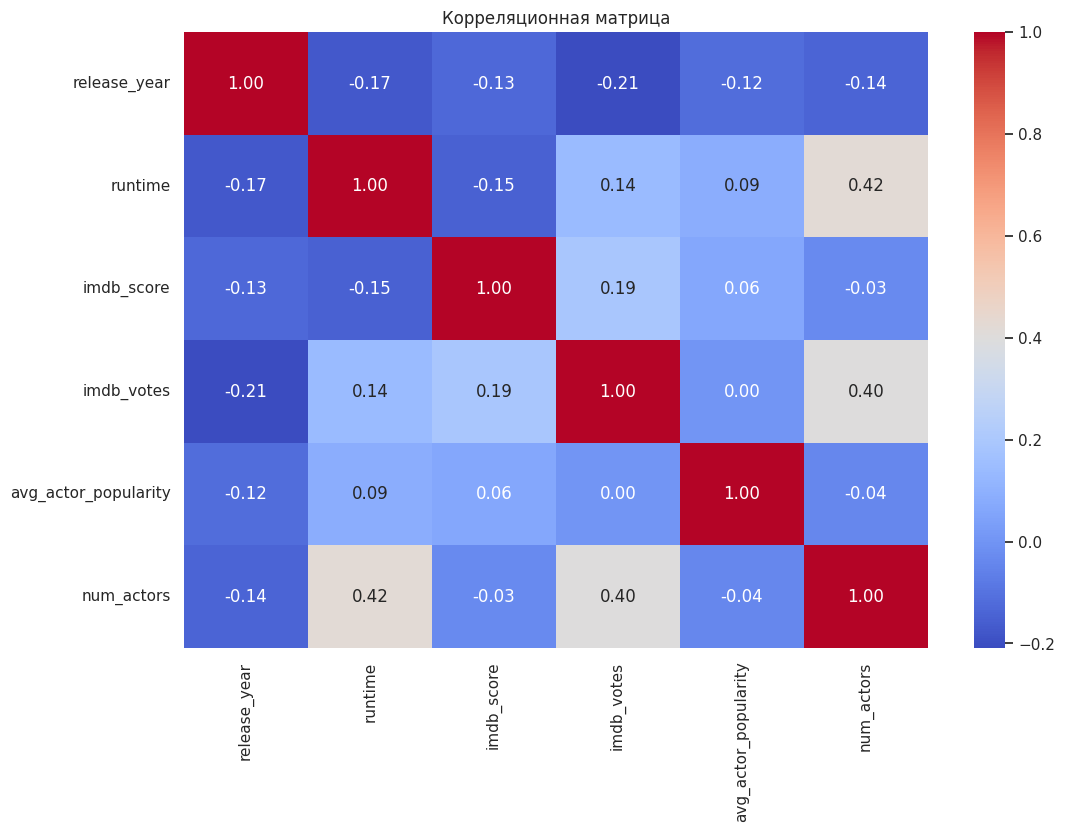

In [55]:
# Корреляционная матрица
corr_matrix = titles_df[numeric_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

Низкая корреляция между признаками - признаки дают разную информацию. Повышенная корреляция между количеством актёров и длительностью - длинные фильмы требующие большое количество актёров.
Повышенная корреляция между количеством актёров и количеством голосов.

Посмотрим на рейтинг по странам:

<ipython-input-42-b214b912e0ac>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


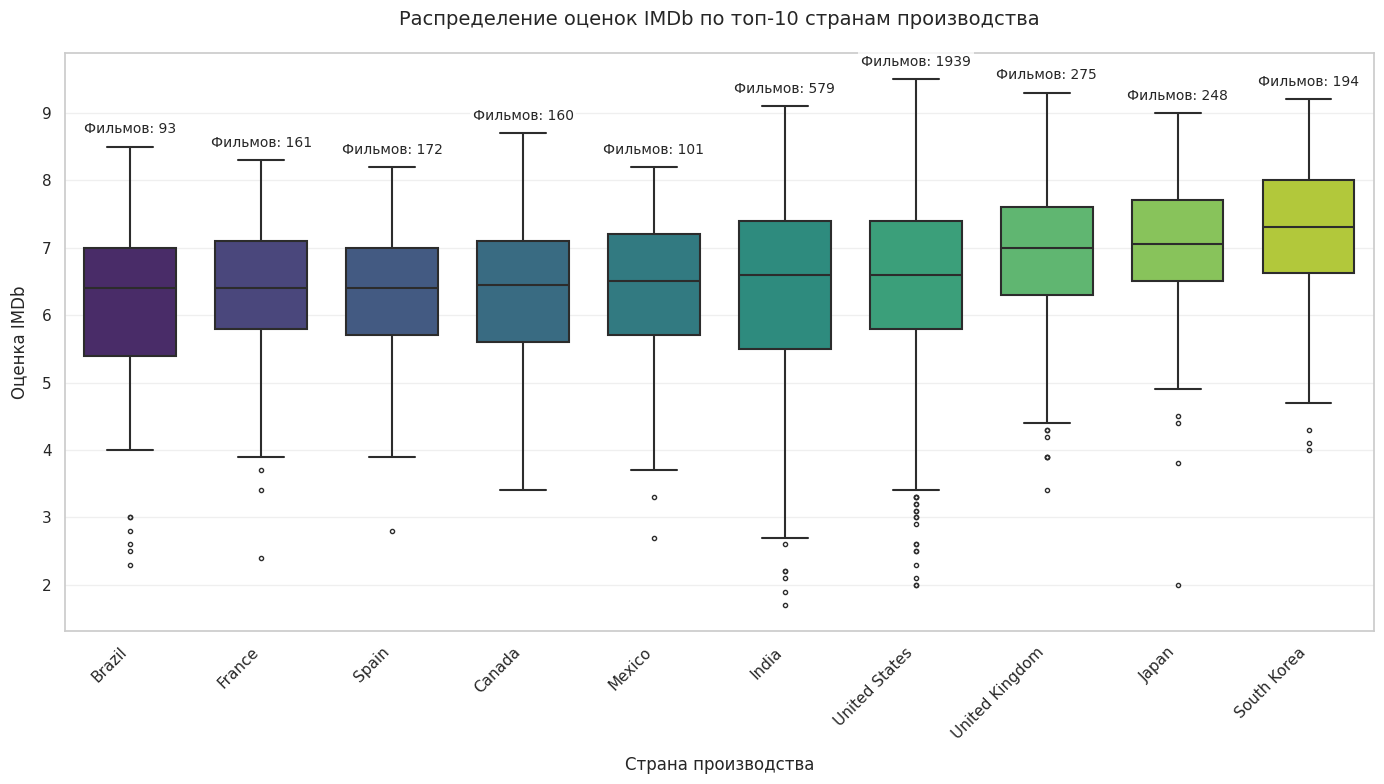

In [42]:
!pip install pycountry
import pycountry

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Функция для преобразования кодов стран в полные названия
def extract_and_convert_country(raw_str):
    if not isinstance(raw_str, str):  # Проверяем, что это строка
        return None
    cleaned = raw_str.strip("[]").replace("'", "").replace("\"", "").strip()
    if not cleaned:
        return None
    codes = [code.strip() for code in cleaned.split(",") if code.strip()]
    if not codes:
        return None
    code = codes[0]
    country = pycountry.countries.get(alpha_2=code.upper())
    return country.name if country else None

titles_df["production_countries_full"] = titles_df["production_countries"].apply(extract_and_convert_country)

valid_titles = titles_df[titles_df["production_countries_full"].notnull()]
filtered_titles = valid_titles.copy()
# Заменяем название Южной Кореи на более короткое
filtered_titles["production_countries_full"] = filtered_titles["production_countries_full"].replace(
    "Korea, Republic of", "South Korea")

# Выбираем топ-10 стран по количеству фильмов
top_countries = filtered_titles["production_countries_full"].value_counts().head(10).index
filtered_df = filtered_titles[filtered_titles["production_countries_full"].isin(top_countries)]

# Сортируем страны по медианному значению IMDb
country_order = filtered_df.groupby("production_countries_full")["imdb_score"].median().sort_values().index

plt.figure(figsize=(14, 8))
ax = sns.boxplot(
    x="production_countries_full",
    y="imdb_score",
    data=filtered_df,
    order=country_order,
    palette="viridis",
    width=0.7,
    linewidth=1.5,
    fliersize=3
)

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Страна производства", fontsize=12, labelpad=10)
plt.ylabel("Оценка IMDb", fontsize=12, labelpad=10)
plt.title("Распределение оценок IMDb по топ-10 странам производства", fontsize=14, pad=20)

# Добавляем аннотации с количеством фильмов
counts = filtered_df["production_countries_full"].value_counts().loc[country_order]
max_scores = filtered_df.groupby("production_countries_full")["imdb_score"].max().loc[country_order]

for i, country in enumerate(country_order):
    count = counts[country]
    y_pos = max_scores[country] + 0.15
    ax.text(
        i, y_pos, f"Фильмов: {count}",
        ha='center',
        va='bottom',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2)
    )

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.show()

Посмотрим на рейтинг по актёрам:

<ipython-input-38-eef478bdd445>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


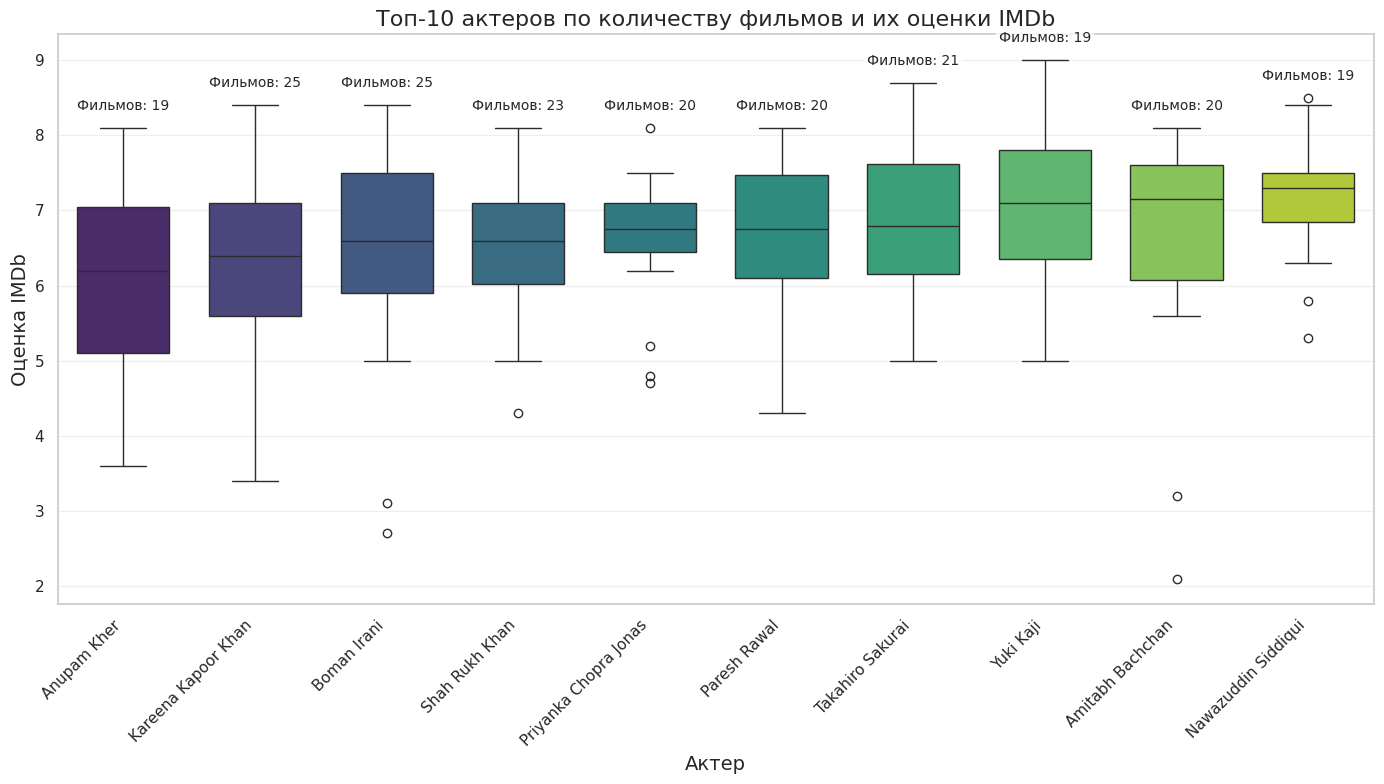

In [38]:

top_actors = credits_df[credits_df['role'] == 'ACTOR']['name'].value_counts().head(10)
top_actor_names = top_actors.index

actor_movies = credits_df[(credits_df['name'].isin(top_actor_names)) & (credits_df['role'] == 'ACTOR')]

actor_scores = pd.merge(actor_movies[['id', 'name']],
                       titles_df[['id', 'imdb_score']],
                       on='id')

# Сортируем по медианной оценке
actor_order = actor_scores.groupby('name')['imdb_score'].median().sort_values().index

plt.figure(figsize=(14, 8))
ax = sns.boxplot(
    x='name',
    y='imdb_score',
    data=actor_scores,
    order=actor_order,
    palette="viridis",
    width=0.7
)

for i, actor in enumerate(actor_order):
    count = top_actors[actor]
    ax.text(i,
            actor_scores[actor_scores['name'] == actor]['imdb_score'].max() + 0.2,
            f'Фильмов: {count}',
            ha='center',
            va='bottom',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))

plt.title('Топ-10 актеров по количеству фильмов и их оценки IMDb', fontsize=16)
plt.xlabel('Актер', fontsize=14)
plt.ylabel('Оценка IMDb', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<ipython-input-39-e9825b7b129e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


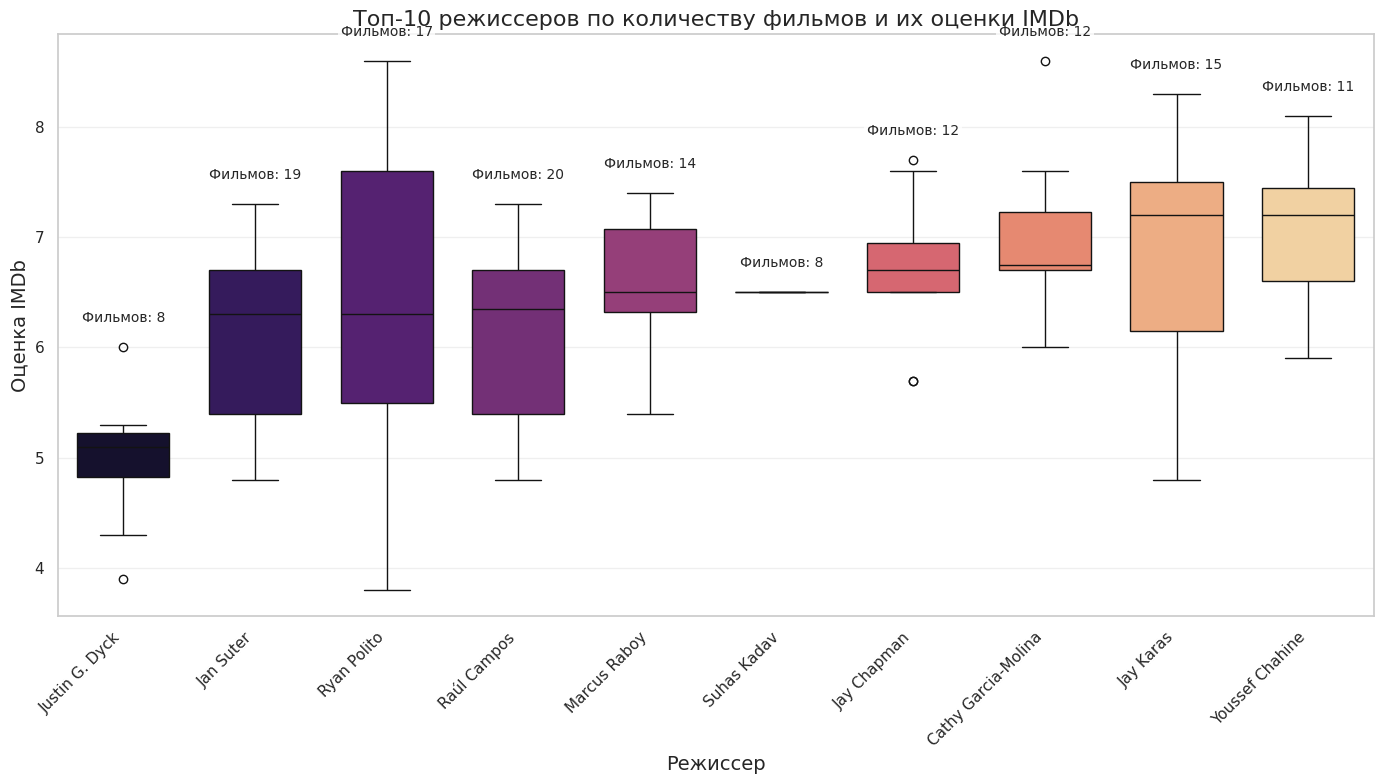

In [39]:

top_directors = credits_df[credits_df['role'] == 'DIRECTOR']['name'].value_counts().head(10)
top_director_names = top_directors.index

director_movies = credits_df[(credits_df['name'].isin(top_director_names)) & (credits_df['role'] == 'DIRECTOR')]

director_scores = pd.merge(director_movies[['id', 'name']],
                          titles_df[['id', 'imdb_score']],
                          on='id')

# Сортируем по медианной оценке
director_order = director_scores.groupby('name')['imdb_score'].median().sort_values().index

plt.figure(figsize=(14, 8))
ax = sns.boxplot(
    x='name',
    y='imdb_score',
    data=director_scores,
    order=director_order,
    palette="magma",
    width=0.7
)

for i, director in enumerate(director_order):
    count = top_directors[director]
    ax.text(i,
            director_scores[director_scores['name'] == director]['imdb_score'].max() + 0.2,
            f'Фильмов: {count}',
            ha='center',
            va='bottom',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))

plt.title('Топ-10 режиссеров по количеству фильмов и их оценки IMDb', fontsize=16)
plt.xlabel('Режиссер', fontsize=14)
plt.ylabel('Оценка IMDb', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Посмотрим на жанры:

<ipython-input-59-ec5cec937682>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.head(15).values, y=genre_counts.head(15).index, palette='viridis')
<ipython-input-59-ec5cec937682>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_scores.head(15).values, y=genre_scores.head(15).index, palette='rocket')


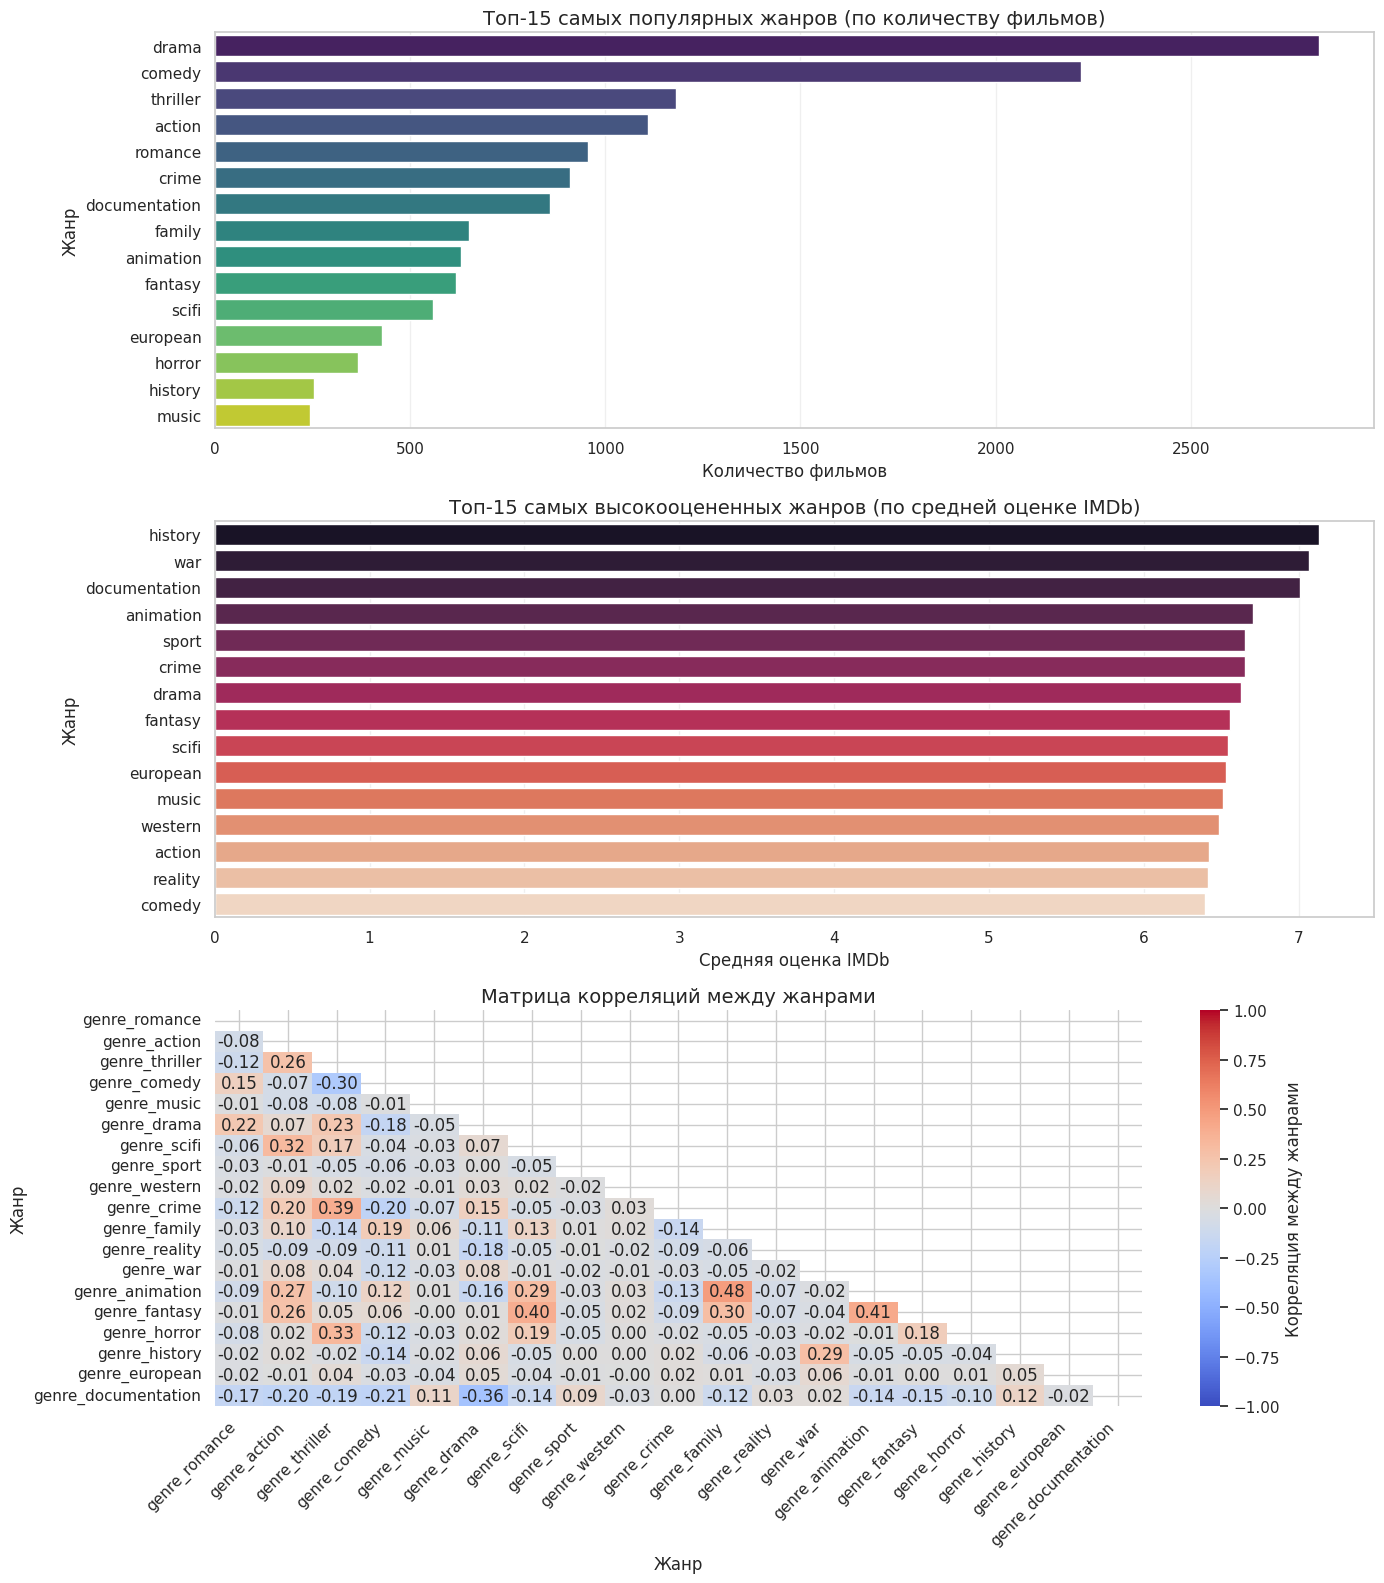

In [59]:
from ast import literal_eval

# Преобразуем жанры в список
titles_df['genres_list'] = titles_df['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else [])
all_genres = list(set(g for genres in titles_df['genres_list'] for g in genres))

# Создаем бинарные колонки для каждого жанра
for genre in all_genres:
    titles_df[f'genre_{genre}'] = titles_df['genres_list'].apply(lambda x: genre in x)

# 1. График популярности жанров (по количеству фильмов)
genre_counts = pd.Series({g: titles_df[f'genre_{g}'].sum() for g in all_genres}).sort_values(ascending=False)

plt.figure(figsize=(14, 16))
plt.subplot(3, 1, 1)
sns.barplot(x=genre_counts.head(15).values, y=genre_counts.head(15).index, palette='viridis')
plt.title('Топ-15 самых популярных жанров (по количеству фильмов)', fontsize=14)
plt.xlabel('Количество фильмов', fontsize=12)
plt.ylabel('Жанр', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# 2. График высокооцененных жанров (по средней оценке)
genre_scores = pd.Series({
    g: titles_df[titles_df[f'genre_{g}']]['imdb_score'].mean()
    for g in all_genres
}).sort_values(ascending=False)

plt.subplot(3, 1, 2)
sns.barplot(x=genre_scores.head(15).values, y=genre_scores.head(15).index, palette='rocket')
plt.title('Топ-15 самых высокооцененных жанров (по средней оценке IMDb)', fontsize=14)
plt.xlabel('Средняя оценка IMDb', fontsize=12)
plt.ylabel('Жанр', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# 3. Матрица корреляций между жанрами (какие жанры встречаются вместе)
genre_cols = [f'genre_{g}' for g in all_genres]
genre_corr = titles_df[genre_cols].corr()

# Оставляем только верхний треугольник, чтобы избежать дублирования
mask = np.triu(np.ones_like(genre_corr, dtype=bool))

plt.subplot(3, 1, 3)
sns.heatmap(
    genre_corr,
    mask=mask,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Корреляция между жанрами'}
)
plt.title('Матрица корреляций между жанрами', fontsize=14)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Жанр', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

Что редко встречается: комедия + триллер, документалки + драма

Частые комбинации: триллер + crime\хоррор, научная фантастика + экшен, фэнтези + научная фантастика, анимация + семейное\фэнтези

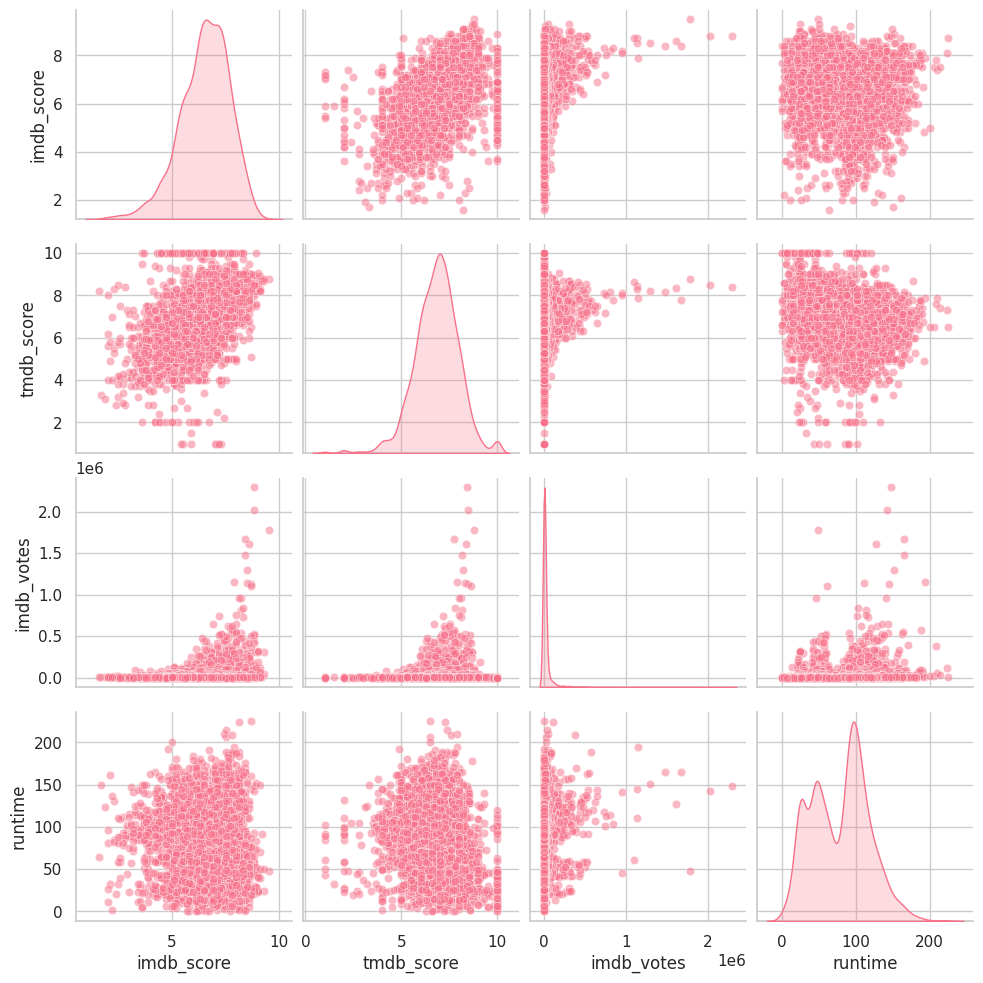

In [45]:

# Выбираем нужные числовые колонки
selected_columns = ["imdb_score", "tmdb_score", "imdb_votes", "runtime"]
pairplot_df = titles_df[selected_columns].dropna()

# Строим pairplot
sns.pairplot(pairplot_df, diag_kind="kde", plot_kws={'alpha': 0.5})

plt.show()

Для предсказания оуенки фильма (imdb_score) мы выбрали градиентный бустинг, потому что он хорошо справляется с нелинейными зависимостями, учитывает сложные взаимодействия между признаками и хорошо масштабируется.

Разделение данных:

In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Добавляем новые признаки в DataFrame
titles_df["num_genres"] = titles_df[[f"genre_{g}" for g in unique_genres]].sum(axis=1)
titles_df["actor_score_combo"] = titles_df["avg_actor_popularity"] * titles_df["has_top_actor"]

# Обновляем список признаков
features = ["release_year", "runtime", "avg_actor_popularity", "num_actors", "has_top_actor"] + \
           [f"genre_{g}" for g in unique_genres] + \
           [f"country_{c}" for c in unique_countries] + ["num_genres", "actor_score_combo"]

numeric_features = ["release_year", "runtime", "avg_actor_popularity", "num_actors", "has_top_actor", "num_genres", "actor_score_combo"]

# Разделение на train/test
X = titles_df[features]
y = titles_df["imdb_score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучение модели:

In [47]:
# Нормализация числовых данных
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, [f"genre_{g}" for g in unique_genres] + [f"country_{c}" for c in unique_countries])
    ]
)

# Градиентный бустинг XGBoost
from xgboost import XGBRegressor
xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(objective="reg:squarederror", random_state=42))
])

# Гиперпараметры для подбора
param_grid = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 5, 7],
    "model__subsample": [0.8, 1.0],
}

# GridSearchCV для подбора параметров
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=1)
grid_search.fit(X_train, y_train)

# Лучшая модель
best_model = grid_search.best_estimator_

# Предсказания и оценка
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}")

Лучшие параметры: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}
MAE: 0.7660
MSE: 1.0040
R2: 0.2803


Кластеризация фильмов по признакам

Цель: Мы хотим автоматически разделить фильмы на группы (кластеры), основываясь на количественных характеристиках. Это позволяет понять, какие типы фильмов существуют в датасете, какие у них общие свойства, и как можно использовать эту информацию, например, для рекомендаций или анализа рынка.

Используемые признаки: runtime — длительность фильма; release_year — год выхода; imdb_score — рейтинг IMDb; imdb_votes — количество голосов на IMDb; жанры.

In [48]:
import numpy as np
def enhanced_feature_engineering(df):
    features = pd.DataFrame({
        'runtime': df['runtime'] / 240,
        'release_year': (df['release_year'] - 1940) / 82,
        'imdb_score': df['imdb_score'],
        'log_votes': np.log1p(df['imdb_votes'])
    })
    genre_cols = [c for c in df.columns if c.startswith('genre_')]
    features = pd.concat([features, df[genre_cols]], axis=1)

    numeric_cols = ['runtime', 'release_year', 'imdb_score', 'log_votes']
    features[numeric_cols] = StandardScaler().fit_transform(features[numeric_cols])

    return features

In [49]:
from sklearn.cluster import OPTICS, SpectralClustering
from sklearn.ensemble import IsolationForest

def hybrid_clustering(features):
    # Первый этап: выделяем аномалии
    iso = IsolationForest(contamination=0.1)
    outliers = iso.fit_predict(features)

    # Второй этап: кластеризация
    optics = OPTICS(
    min_samples=20,
    xi=0.03,
)
    clusters = optics.fit_predict(features)

    # Третий этап: уточнение спектральной кластеризацией
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    if n_clusters > 1:
        spectral = SpectralClustering(n_clusters=n_clusters,
                                    affinity='nearest_neighbors')
        refined = spectral.fit_predict(features)
        return refined
    return clusters

In [50]:
from umap import UMAP
def postprocess_clusters(df, features, labels):
    # Удаляем шумовые точки
    filtered = df[labels != -1].copy()
    filtered_features = features[labels != -1]
    filtered_labels = labels[labels != -1]
    filtered['cluster'] = filtered_labels

    # Визуализаци
    plt.figure(figsize=(14, 10))
    reducer = UMAP(n_components=2, random_state=42)
    emb = reducer.fit_transform(filtered_features)

    sns.scatterplot(
        x=emb[:, 0],
        y=emb[:, 1],
        hue=filtered_labels,
        palette='tab20',
        alpha=0.7,
        s=50
    )
    plt.title(f'Кластеры {filtered["type"].iloc[0]}', fontsize=16)
    plt.show()

    # Анализ статистик
    print("\n=== Основные характеристики кластеров ===")
    stats = filtered.groupby('cluster').agg({
        'runtime': 'median',
        'release_year': 'median',
        'imdb_score': ['mean', 'count'],
        'imdb_votes': 'median'
    })
    print(stats.round(1))

    # Анализ жанров и примеров
    genre_cols = [c for c in df.columns if c.startswith('genre_')]
    if genre_cols:
        print("\n=== Анализ кластеров ===")
        for cluster in sorted(filtered['cluster'].unique()):
            cluster_data = filtered[filtered['cluster'] == cluster]

            # Жанровая статистика
            genre_freq = cluster_data[genre_cols].mean().sort_values(ascending=False)

            print(f"\nКластер {cluster} ({len(cluster_data)} объектов):")
            print("Топ-3 жанра:")
            for genre, freq in genre_freq.head(3).items():
                print(f"  {genre.replace('genre_', '')}: {freq:.1%}")

            # Характеристики кластера
            print("\nХарактеристики:")
            print(f"  Средний рейтинг: {cluster_data['imdb_score'].mean():.1f}")
            print(f"  Медианный год: {cluster_data['release_year'].median():.0f}")
            print(f"  Медианная продолжительность: {cluster_data['runtime'].median():.0f} мин")

            # Лучшие представители
            top_items = cluster_data.nlargest(3, 'imdb_score')
            print("\nЛучшие представители:")
            for _, row in top_items.iterrows():
                print(f"  {row['title']} ({row['release_year']}), {row['imdb_score']:.1f}")

            print("-" * 50)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


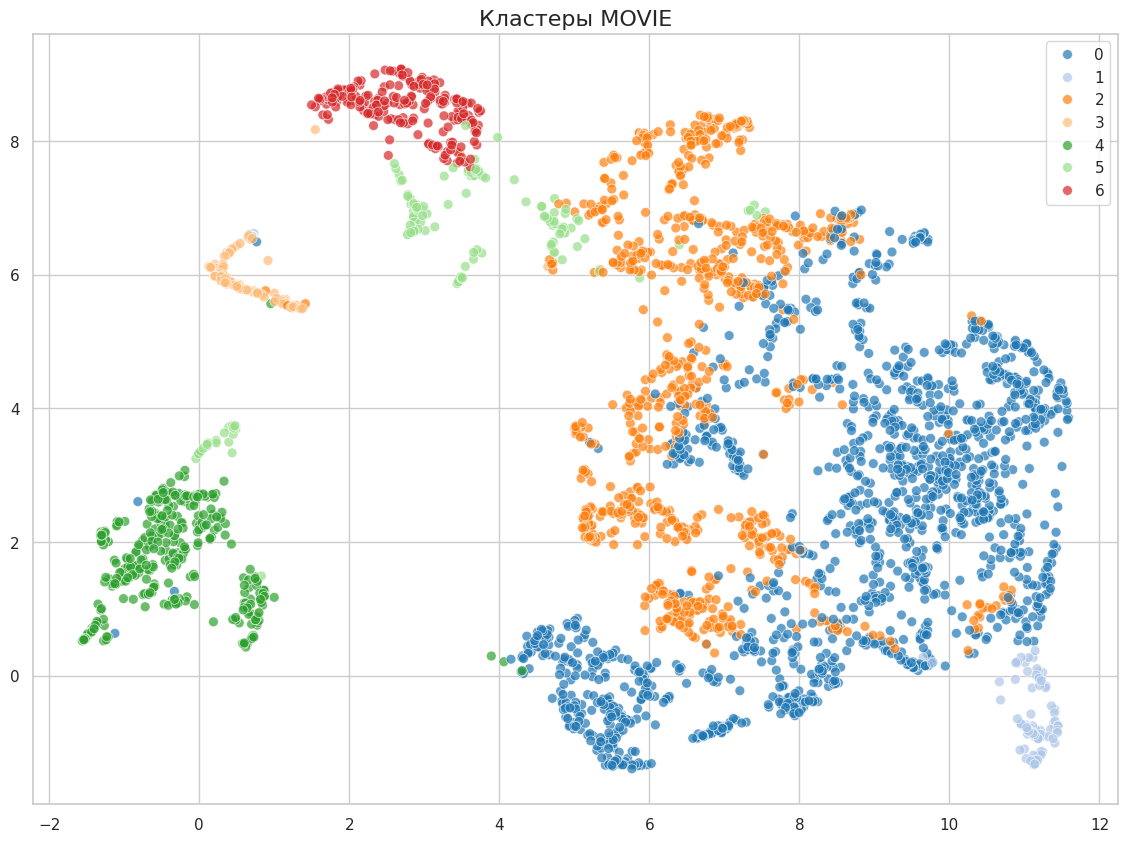


=== Основные характеристики кластеров ===
        runtime release_year imdb_score       imdb_votes
         median       median       mean count     median
cluster                                                 
0         107.0       2018.0        6.3  1596     6380.5
1         115.0       1986.0        6.7   100      892.0
2         101.0       2018.0        5.6   911     1452.0
3          66.0       2017.0        7.0    91     1729.0
4          91.0       2019.0        7.1   363     1400.0
5          52.0       2019.0        5.9   155       72.0
6          63.0       2018.0        6.8   213     1274.0

=== Анализ кластеров ===

Кластер 0 (1596 объектов):
Топ-3 жанра:
  drama: 75.6%
  thriller: 47.2%
  action: 34.5%

Характеристики:
  Средний рейтинг: 6.3
  Медианный год: 2018
  Медианная продолжительность: 107 мин

Лучшие представители:
  Major (2022), 9.1
  C/o Kancharapalem (2018), 8.9
  Forrest Gump (1994), 8.8
--------------------------------------------------

Кластер 1 (100 о

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


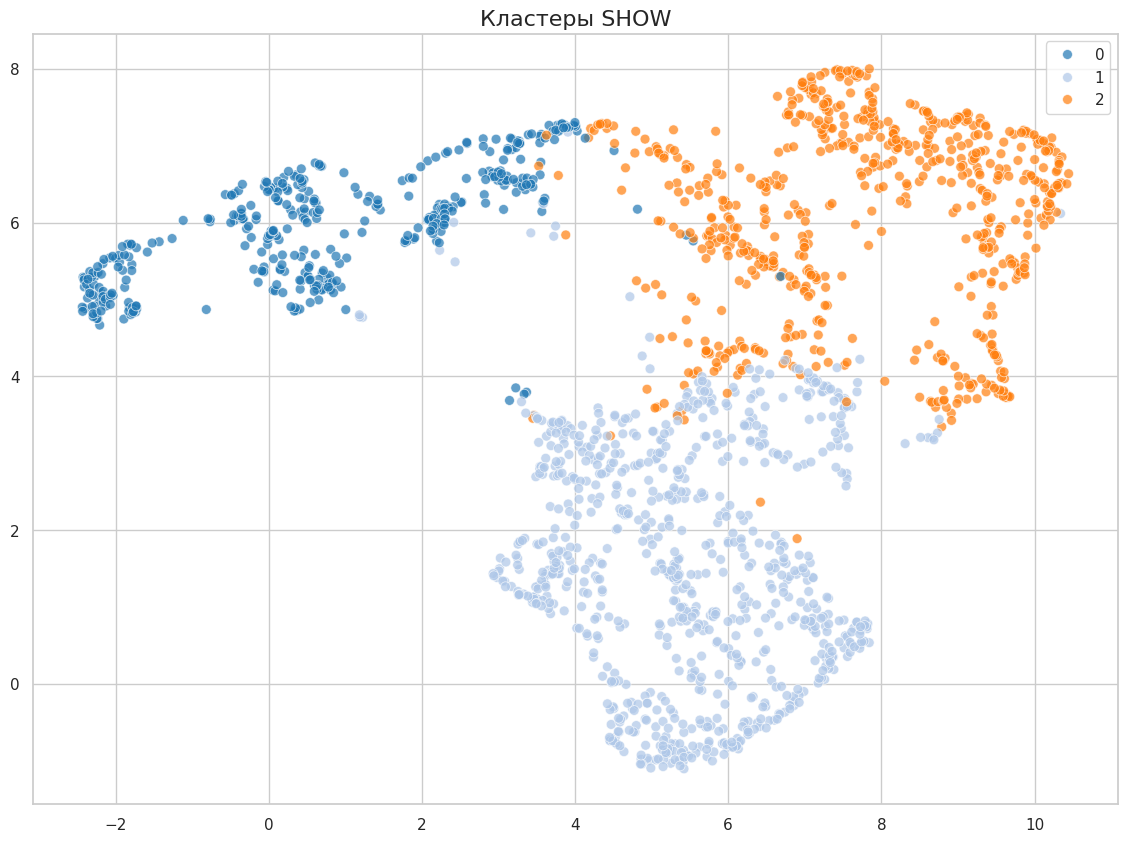


=== Основные характеристики кластеров ===
        runtime release_year imdb_score       imdb_votes
         median       median       mean count     median
cluster                                                 
0          44.0       2020.0        6.9   417     1131.0
1          47.0       2019.0        7.2   852     4027.0
2          24.0       2018.0        6.7   670      915.5

=== Анализ кластеров ===

Кластер 0 (417 объектов):
Топ-3 жанра:
  documentation: 68.1%
  reality: 40.0%
  crime: 21.3%

Характеристики:
  Средний рейтинг: 6.9
  Медианный год: 2020
  Медианная продолжительность: 44 мин

Лучшие представители:
  Our Planet (2019), 9.3
  The Last Dance (2020), 9.1
  Leah Remini: Scientology and the Aftermath (2016), 9.0
--------------------------------------------------

Кластер 1 (852 объектов):
Топ-3 жанра:
  drama: 94.8%
  thriller: 38.3%
  crime: 30.2%

Характеристики:
  Средний рейтинг: 7.2
  Медианный год: 2019
  Медианная продолжительность: 47 мин

Лучшие представители

In [51]:
def full_clustering_pipeline(df, content_type):
    # Фильтрация по типу
    subset = df[df['type'] == content_type].copy()
    if len(subset) < 100:
        print(f"Недостаточно данных ({len(subset)}). Минимум 100.")
        return

    features = enhanced_feature_engineering(subset)
    labels = hybrid_clustering(features)
    postprocess_clusters(subset, features, labels)

full_clustering_pipeline(titles_df, 'MOVIE')
full_clustering_pipeline(titles_df, 'SHOW')

Результаты кластеризации фильмов
1. Кластер 0: "Современные массовые комедии" (903 фильма)
Характеристики: Самый крупный кластер, современные (2018 г.) фильмы средней продолжительности (~100 мин) с низким средним рейтингом (5.6)

Жанры: Доминируют комедии (83%) с элементами драмы и романтики

Особенности: Низкое количество голосов (медиана 1458) указывает на нишевую аудиторию

2. Кластер 1: "Классика кино" (100 фильмов)
Характеристики: Старые фильмы (медианный 1986 г.), длинные (115 мин), более высокие оценки (6.7)

Жанры: Драмы (69%) с элементами экшена

Особенности: Включает культовые фильмы ("Full Metal Jacket", "Once Upon a Time in America")

3. Кластер 2: "Мейнстрим-драмы" (1599 фильмов)
Характеристики: Самый популярный кластер (медиана 6391 голосов), современные (2018 г.)

Жанры: Драмы (75%) с триллерами и экшеном

Особенности: Включает как артхаус ("C/o Kancharapalem"), так и блокбастеры

4. Кластер 3: "Детский контент" (166 фильмов)
Характеристики: Короткие (54 мин) современные (2019 г.) фильмы с низкими рейтингами (5.9)

Жанры: Комедии (58%) и анимация (45%)

Особенность: Высокие оценки топ-фильмов (9.1) при низком среднем - детская аудитория редко ставит оценки

5. Кластер 4: "Премиум-документалистика" (363 фильма)
Характеристики: Высокие рейтинги (7.1), стандартная длина (~90 мин)

Жанры: 99.7% документальные, иногда с музыкальными элементами

Тренд: Растущий спрос на качественные документальные проекты

6. Кластер 5: "Стендап-спешлы" (91 фильм)
Характеристики: Короткие (66 мин) комедийные спешлы (98.9%)

Особенности: Высокие рейтинги (7.0+) у топовых комиков (Bo Burnham, Bill Burr)

7. Кластер 6: "Комедийные спешлы" (207 фильмов)
Характеристики: Очень короткие (63 мин), высокая концентрация комедий (98.6%)

Отличие от кластера 5: Более современные (2018 vs 2017) и выше рейтинги (6.8 vs 7.0)


Результаты кластеризации сериалов
1. Документальные и реалити-сериалы (417)

Характеристики: 44 мин/эп., 2020 г., рейтинг 6.9 (~1100 голосов)

Жанры: Документальные (68%), реалити (40%), криминал (21%)

Топ: Our Planet (9.3), The Last Dance (9.1)

Особенности: Премиум-контент, социальная тематика, высокая оценка качества

2. Драмы премиум-класса (852)

Характеристики: 47 мин/эп., 2019 г., рейтинг 7.2 (~4000 голосов)

Жанры: Драмы (95%) + триллеры (38%)/криминал (30%)

Топ: Breaking Bad (9.5), Reply 1988 (9.2)

Особенности: Культовые сериалы, международные проекты, высокая вовлеченность

3. Комедийная анимация (670)

Характеристики: 24 мин/эп., 2018 г., рейтинг 6.7 (~915 голосов)

Жанры: Комедии (70%), анимация (57%), семейные (42%)

Топ: Avatar: The Last Airbender (9.3), Okupas (9.0)

Особенности: Семейный формат, международный контент, оптимальная длина для ТВ
